# Salary Predictions Based on Job Descriptions

## Part 1 - DEFINE

### ---- 1 Define the problem ----

We have to first examine a certain set of job postings and their salaries. After understanding the data and how the salaries are based on various factors, we have to predict salaries for a different set of job postings.

In [1]:
#Imported the required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import percentile

#For Label Encoding
from sklearn.preprocessing import LabelEncoder

#For Normalization
from sklearn.preprocessing import MinMaxScaler

#For Linear Regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#For Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

# For Errors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For Decision Tree Regression model
from sklearn.tree import DecisionTreeRegressor

# For Random Forest and Gradient Boosting Regression model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# For calculating the Cross Validation Score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#Author Information
__author__ = "Rini Lali"
__email__ = "rinilali.91@outlook.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
# File path of the Data that is used for training the model
path_train_f="/FirstProject/data/train_features.csv"
path_train_s="/FirstProject/data/train_salaries.csv"

# File path of the data in which the salaries needs to be predicted based on the model
path_test_f="/FirstProject/data/test_features.csv"

# Reading the csv files into dataframes
df_train_f= pd.read_csv(path_train_f,header=0)
df_train_s= pd.read_csv(path_train_s,header=0)
df_test_f= pd.read_csv(path_test_f,header=0)

In [3]:
# Describe the data to understand what type of data is present in the files
df_train_f.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [4]:
# Summary of the data frame that needs to be examined to predict the salaries
df_train_f.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [5]:
# Checked if column Job Id is unique
df_train_f['jobId'].is_unique

True

In [6]:
# Merged and created one dataframe "data_final" with all the information(train_features+train_salaries)
data_final = pd.merge(df_train_f, df_train_s,  
                   on='jobId',  
                   how='inner')
data_final.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
#Statistical summary of the columns
data_final.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [8]:
# Dropping the dataframes as they are no longer in use
del(df_train_f)
del(df_train_s)

In our data files, we have jobId, companyId, categorical columns (jobType, degree, major, industry) and numerical columns (yearsExperience, milesFromMetropolis, salary) that will be used to train/test the model.
jobId - represents a unique identifier for the job posting

### ---- 3 Clean the data ----
Looking for duplicate data, invalid data (e.g. salaries <=0), or corrupted data.

In [9]:
# Checked for duplicates and removed them
duplicateRowsDF=data_final.duplicated()
data_final.drop_duplicates()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


There were no duplicates found in the data set.

In [10]:
# Checking for missing Data if any
missing_data = data_final.isnull().sum()
missing_data.head()

jobId        0
companyId    0
jobType      0
degree       0
major        0
dtype: int64

In [11]:
# Checked for missing data using value-counts function
missing_data = data_final.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64

salary
False    1000000
Name: salary, dtype: int64



No data was missing in the data set.

In [12]:
# Checking for invalid Data in the columns
sal_incrr=data_final.index[data_final['salary']==0].to_list()
sal_incrr

[30559, 495984, 652076, 816129, 828156]

We found that, in the salary column, there was invalid data.

In [13]:
# Replaced the columns having invalid Data with the mean salary for the respective job type
grp = data_final.groupby('jobType')   
grp['salary'].agg([np.mean])

i=0
len_sal=len(sal_incrr)
while i < len_sal:
    str_job=data_final.loc[sal_incrr[i],'jobType']
    sal=round(grp.get_group(str_job)['salary'].mean())
    data_final.loc[sal_incrr[i],'salary']=sal
    i += 1

In [14]:
# Replaced the invalid data and checked again if any invalid data is present
sal_incrr1=data_final.index[data_final['salary']==0].to_list()
sal_incrr1
#data_final.to_csv("C:/Users/abhis/Downloads/Rini/Studying/DSDJ/FirstProject/data/Train_Data.csv", index=False)

[]

In [15]:
# Stored the cleaned Data is a new CSV file for further analysis
data_final.to_csv("/FirstProject/data/Train_Data.csv", index=False)

In [16]:
del(data_final)

We have prepared and cleaned the data for further analysis. The final data is stored in the "Train_Data" csv file.

### ---- 4 Explore the data (EDA) ----

Preliminary step in Data Analysis :-

     1) We need to summarize the main characteristics of data
     2) Understand the data
     3) Check for relationships betweens the feature variables present in the data
     

In [17]:
# Get the final data from the new file in the dataframe "df_final"
train_final="/FirstProject/data/Train_Data.csv"
df_final=pd.read_csv(train_final,header=0)
df_final.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [18]:
df_final.shape

(1000000, 9)

#### Descriptive Analysis in EDA

Describing and summarizing the categorical and numerical data

In [19]:
# Checking the counts in categorical values job type, industry, companyId, degree, major. 
# this shows how the data is distributed over various categorical variables

job_type_counts=df_final["jobType"].value_counts()
print(job_type_counts)

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64


In [20]:
industry_counts=df_final["industry"].value_counts()
print(industry_counts)

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


In [21]:
degree_counts=df_final["degree"].value_counts()
print(degree_counts)

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64


In [22]:
major_counts=df_final["major"].value_counts()
print(major_counts)

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64


From the value counts, we could say that the data present in the Train data set is distributed uniformly and we have enough data(unique values) for each category to analyze and make predictions.

#### Data Visualization

Using Box Plots to understand the salary distribution by various features.

Box plot will provide us the below data :-

Median of the data

Upper Quartile shows the 75th percentile

Lower Quartile shows the 25th percentile 

Interquartile Range(IQR) represents the data between the Upper and Lower Quartile.

Lower and Upper Extremes which are calculated as 1.5 times the IQR above the 75th percentile, and as 1.5 times the IQR below the 25th percentile.

It will also help us in identifying the outliers if any.

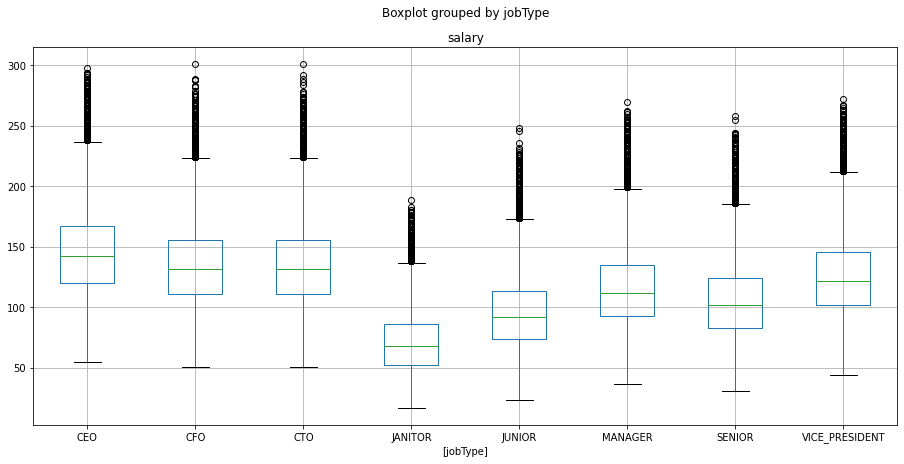

In [23]:
# Boxplot for jobType and salary
bp_jb=df_final.boxplot(column=['salary'],by=['jobType'], rot=0, fontsize=10, figsize=(15,7))

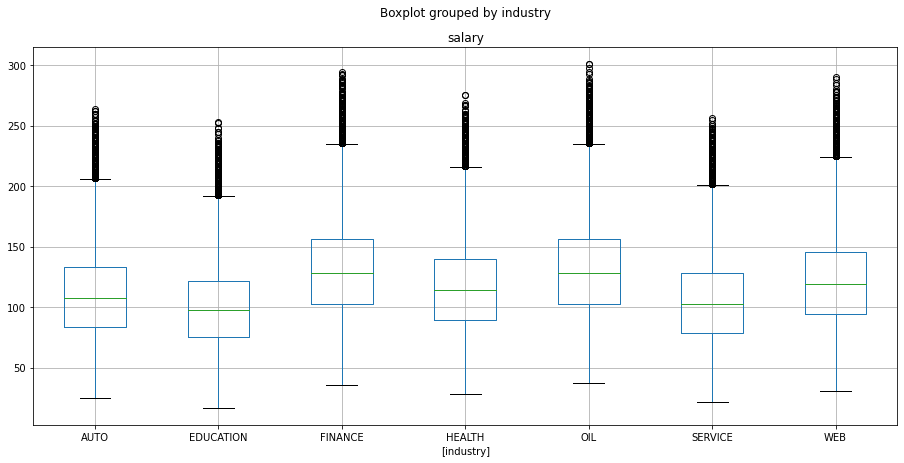

In [24]:
# Boxplot for industry and salary
bp_in=df_final.boxplot(column=['salary'],by=['industry'], rot=0, fontsize=10, figsize=(15,7))

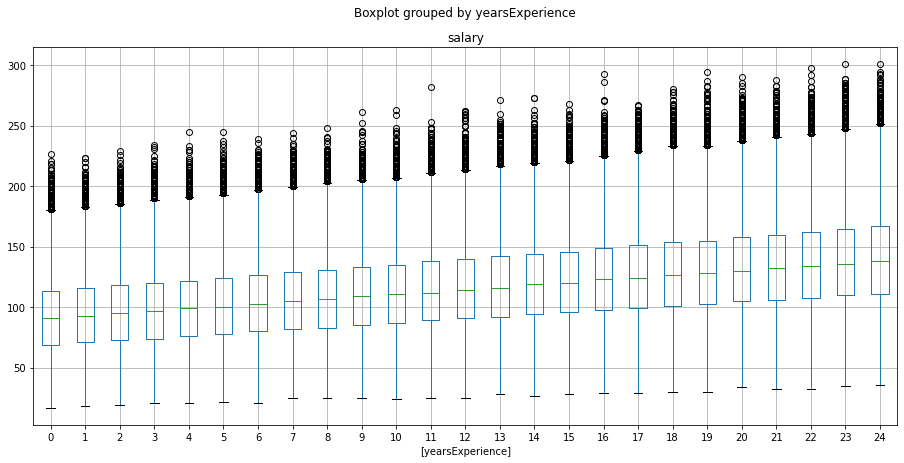

In [25]:
# Boxplot for Experience and salary
bp_exp=df_final.boxplot(column=['salary'],by=['yearsExperience'], rot=0, fontsize=10,figsize=(15,7))

In [26]:
# Identifying the outliers in Salary column in the dataset
sal_q25, sal_q75 = percentile(df_final['salary'], 25), percentile(df_final['salary'], 75)
sal_iqr = sal_q75 - sal_q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (sal_q25, sal_q75, sal_iqr))

# calculate the cutoff
cut_off = sal_iqr * 1.5
lower, upper = sal_q25 - cut_off, sal_q75 + cut_off

# Identify outliers
outliers = [x for x in df_final['salary'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

df_outliers_lower= df_final[(df_final['salary']<lower)]
df_outliers_higher= df_final[(df_final['salary']>upper)]

df_outliers_higher.head()

Percentiles: 25th=88.000, 75th=141.000, IQR=53.000
Identified outliers: 7117


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225


From the data, we can understand that there are 7117 rows which are higher than the upper extreme value and are considered as Outliers.

In [27]:
grp = df_outliers_higher.groupby(['jobType'])['salary'].count()
grp_df = pd.DataFrame(grp)
grp_df.head()

,salary
jobType,
CEO,3227
CFO,1496
CTO,1488
JUNIOR,20
MANAGER,217


After investigating the data, we can say salaries for the roles of 'CEO', 'CFO', 'CTO' and 'Manager' could be high.
There are 20 jobs for 'JUNIOR' job type which needs further investigation.

In [28]:
df_outliers_higher[df_outliers_higher['jobType']=='JUNIOR']

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


After analyzing the data for the JobType 'JUNIOR', we can say that they can be highly paid due to there education and industry in which they are employed.

#### ANOVA ( Analysis of Variance)

ANOVA can be used to find the correlation between different groups of a categorical variable.

This test returns two variables :     
           1) F-test score - calculates the ratio of variation between the groups's mean over the variation within each of the                              sample groups
           2) p-value      - shows whether the obtained result is statistically significant

If F-score is small, the correlation between the target variable and the groupings is weak.
If F-score is large, the correlation between the target variable and the groupings is strong.

There is a strong correlation between a categorical variable and other variables, if the ANOVA test gives us a large F-test value and a small p-value.

In [29]:
# Checking the correlation between jobType and salary
df_ANOVA=df_final[["jobType","salary"]]
grouped_anova=df_ANOVA.groupby(["jobType"])
anova_res_l=stats.f_oneway(grouped_anova.get_group('JANITOR')['salary'],grouped_anova.get_group('CTO')['salary'])
print(anova_res_l)

F_onewayResult(statistic=307079.0344412673, pvalue=0.0)


In [30]:
# Checking the correlation between degree and salary
df_ANOVA=df_final[["degree","salary"]]
grouped_anova=df_ANOVA.groupby(["degree"])
anova_res_l=stats.f_oneway(grouped_anova.get_group('HIGH_SCHOOL')['salary'],grouped_anova.get_group('MASTERS')['salary'])
print(anova_res_l)

F_onewayResult(statistic=64199.66438514302, pvalue=0.0)


In [31]:
# Checking the correlation between major and salary
df_ANOVA=df_final[["major","salary"]]
grouped_anova=df_ANOVA.groupby(["major"])
anova_res_l=stats.f_oneway(grouped_anova.get_group('MATH')['salary'],grouped_anova.get_group('PHYSICS')['salary'])
print(anova_res_l)

F_onewayResult(statistic=203.34966671974883, pvalue=4.244798582409627e-46)


In [32]:
# Checking the correlation between industry and salary
df_ANOVA=df_final[["industry","salary"]]
grouped_anova=df_ANOVA.groupby(["industry"])
anova_res_l=stats.f_oneway(grouped_anova.get_group('OIL')['salary'],grouped_anova.get_group('HEALTH')['salary'])
print(anova_res_l)

F_onewayResult(statistic=11627.386949306501, pvalue=0.0)


Using the ANOVA method, we found out that salary is correlated with jobType, industry, degree and major variables. The F-value is large and the p-value close to zero which indicates strong correlation between these groups.

In [33]:
# Get the information of all the columns of the final dataset Train_data
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


In [34]:
# Summarize each feature variable(categorical)
df_final[['jobType','industry','degree','major']].describe(include='all')

,jobType,industry,degree,major
count,1000000,1000000,1000000,1000000
unique,8,7,5,9
top,SENIOR,WEB,HIGH_SCHOOL,NONE
freq,125886,143206,236976,532355


We have 8 different values in Job Type, 7 different values in Industry, 5 unique values in Degree and 9 different values in Major category.

In [35]:
# Summarizing the feature variable(numerical)
df_final[['yearsExperience','milesFromMetropolis']].describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


From the statistical summary, the range of the column Experience lies between [0 to 24] and the distance from the metropolitan city lies between [0 to 99].

In [36]:
# Summarizing the target variable (Salary)
df_final['salary'].describe()

count    1000000.000000
mean         116.062383
std           38.717084
min           17.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

From the statistical summary, mean salary is 116. The minimum salary earned is 17 and the maximum is 301.

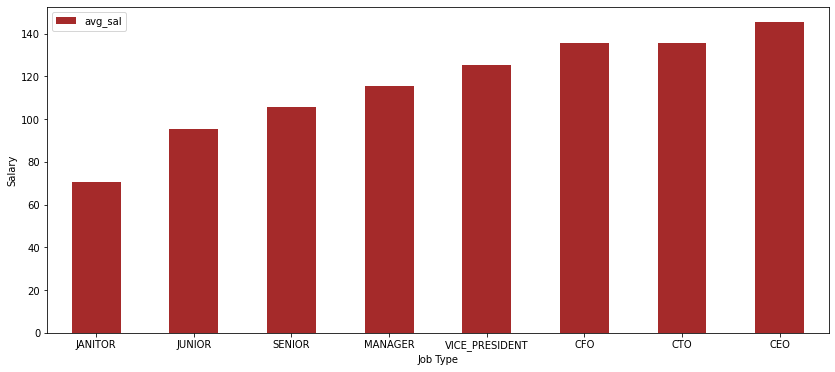

In [37]:
# How target variable 'salary' varies on the feature variable 'jobType'
grp = df_final.groupby('jobType')['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
grp_df=grp_df.sort_values(by='avg_sal')
ax=grp_df.plot.bar(rot=0, fontsize=10,figsize=(14,6),sort_columns=True, color='brown')
ax.set_xlabel("Job Type")
ax.set_ylabel("Salary")
plt.show()

The average salary by job type is lowest for the jobType "Janitor" and highest for "CEO". Job Designation "CEO" has the highest salary.

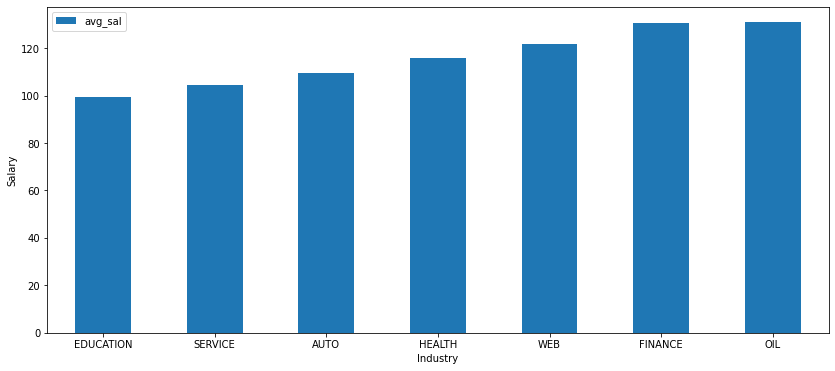

In [38]:
# How target variable 'salary' varies on the feature variable 'industry'
grp = df_final.groupby('industry')['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
grp_df=grp_df.sort_values(by='avg_sal')
ax=grp_df.plot.bar(rot=0, fontsize=10,figsize=(14,6))
ax.set_xlabel("Industry")
ax.set_ylabel("Salary")
plt.show()

From the above bar plot, we can deduce that "Finance" and "Oil" industry have higher salaries than others.

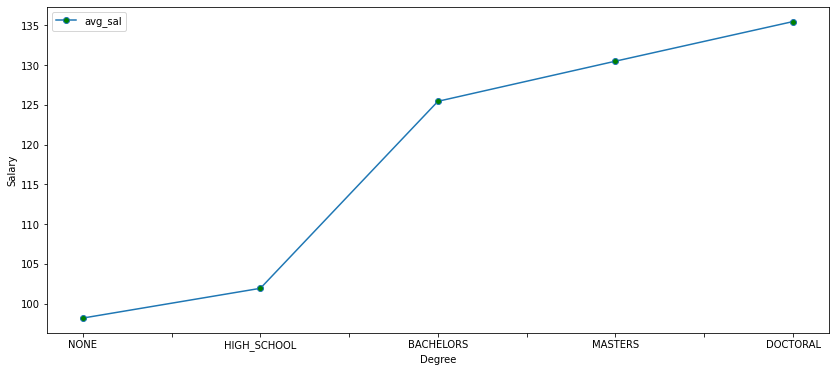

In [39]:
# How target variable 'salary' varies on the feature variable 'degree'
grp = df_final.groupby('degree')['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
grp_df=grp_df.sort_values(by='avg_sal')
ax=grp_df.plot(rot=0, fontsize=10,figsize=(14,6),marker='o',markerfacecolor='green')
ax.set_xlabel("Degree")
ax.set_ylabel("Salary")
plt.show()

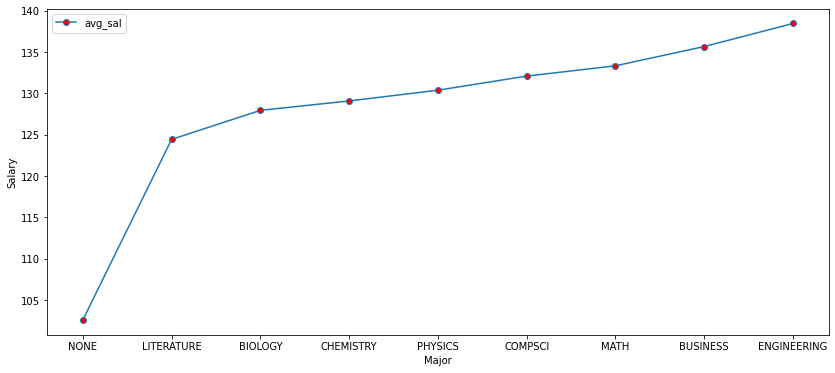

In [40]:
# How target variable 'salary' varies on the feature variable 'major'
grp = df_final.groupby('major')['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
grp_df=grp_df.sort_values(by='avg_sal')
ax=grp_df.plot(rot=0, fontsize=10,figsize=(14,6),marker='o',markerfacecolor='red')
ax.set_xlabel("Major")
ax.set_ylabel("Salary")
plt.show()

After plotting the line graphs, we were able to understand how the salary depends on various feature variables "major" and "degree".
Salaries were low for a jobId having no degree 'None' in the category degree.
Salaries were low for a jobId having no major 'None' in the category major. 
Jobs with educational background of Masters and Doctoral will have higher salaries as compared to jobs having No degree 'None' or "High School".

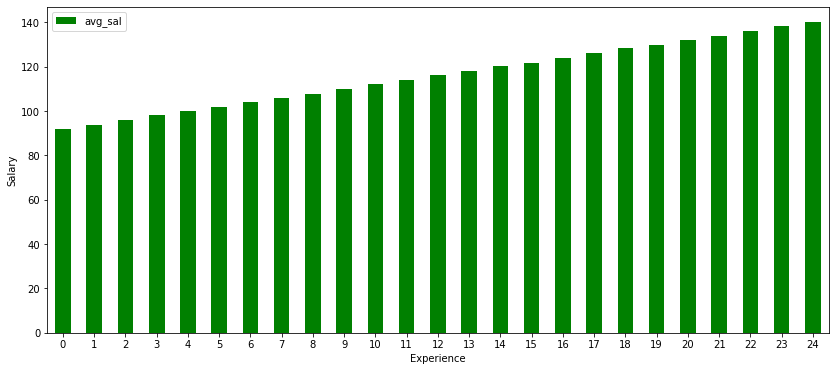

In [41]:
# How target variable 'salary' varies on the feature variable 'Experience'
grp = df_final.groupby('yearsExperience',sort=True)['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
ax=grp_df.plot.bar(rot=0, fontsize=10,figsize=(14,6),color='green')
ax.set_xlabel("Experience")
ax.set_ylabel("Salary")
plt.show()

When we plot the average salary by experience, we found out that salary increases linearly with experience.

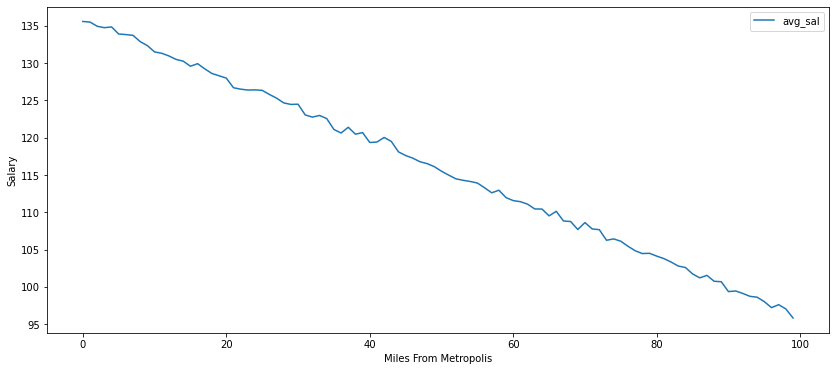

In [42]:
# How target variable 'salary' varies on the feature variable 'milesFromMetropolis'
grp = df_final.groupby('milesFromMetropolis',sort=True)['salary'].agg(avg_sal=(np.mean))
grp_df = pd.DataFrame(grp)
ax=grp_df.plot(rot=0, fontsize=10,figsize=(14,6))
ax.set_xlabel("Miles From Metropolis")
ax.set_ylabel("Salary")
plt.show()

From the above line graph, we understand that salary decreases linearly if we move away from the metropolitan city which is displayed by the feature variable "milesFromMetropolis".

#### Correlation

Checking correlation between milesFromMetropolis, yearsExperience and salary
Pearson Correlation :

Correlation Coefficient

Close to +1 >>>>> large positive correlation

Close to -1 >>>>> large negative correlation

Close to 0  >>>>> No correlation

p-value:

P-value less than .001 >>>>>  strong certainty

P-value between .001 and .05 >>>>> moderate certainty

P-value between .05 and.1 >>>>> weak certainty

P-value larger than .1 >>>>> no certainty

In [43]:
#looking for correlation between features
df_final[["yearsExperience","milesFromMetropolis","salary"]].corr(method ='pearson')
#pearson_coef, p_value=stats.pearsonr(df_final["milesFromMetropolis"],df_final["salary"])

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375012
milesFromMetropolis,0.000673,1.000000,-0.297684
salary,0.375012,-0.297684,1.000000


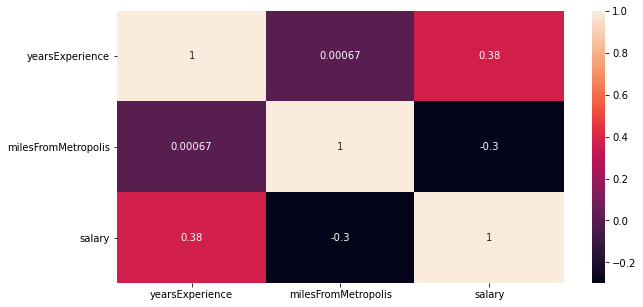

In [44]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.heatmap(df_final.corr(), annot = True)
plt.show()

We found out that there is positive correlation between "salary" and "yearsExperience". 

There is negative correlation between "salary" and "milesFromMetropolis". 

In [45]:
bins_sal=np.linspace(min(df_final["salary"]),max(df_final["salary"]),4)
group_names=["Low","Medium","High"]
df_final["salary-binned"]=pd.cut(df_final["salary"],bins_sal,labels=group_names,include_lowest=True)
df_final.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salary-binned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,Medium


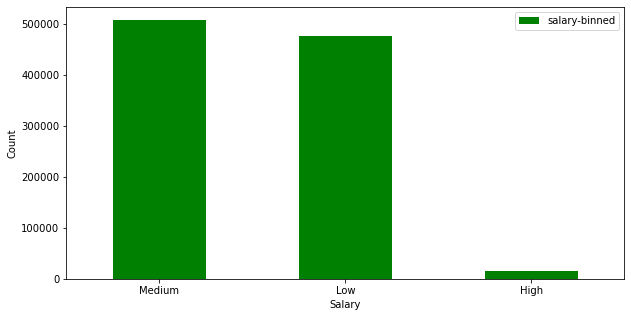

In [46]:
grp = df_final['salary-binned'].value_counts()
grp_df = pd.DataFrame(grp)
ax=grp_df.plot.bar(rot=0, fontsize=10,color=['green'])
ax.set_xlabel("Salary")
ax.set_ylabel("Count")
plt.show()

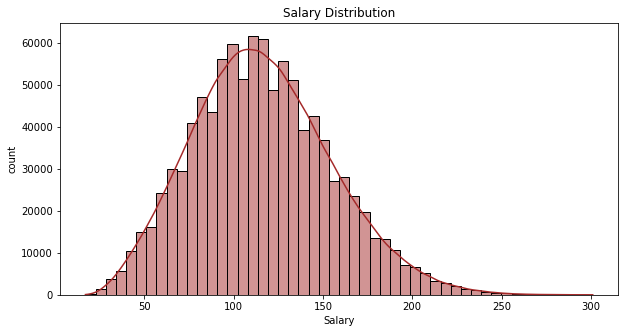

In [47]:
# Salary Distribution

# Plot the histogram
sns.histplot(x="salary",data=df_final,bins=50,kde=True,color='brown')

#set x/y labels and plot title
plt.xlabel("Salary")
plt.ylabel("count")
plt.title("Salary Distribution")
plt.show()

#### Correlation Between Categorical Features and Target Variable Salary

To find correlation between all the feature variables and target salary we will have to convert the categorical values into numeric using label encoding.

In [48]:
# Creating a copy of the dataset

df_corr=df_final.copy(deep=True)
df_corr.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salary-binned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,Medium


In [49]:
df_corr[['companyId','jobType','degree','major','industry']]=df_final[['companyId','jobType','degree','major','industry']].astype('category')

In [50]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   jobId                1000000 non-null  object  
 1   companyId            1000000 non-null  category
 2   jobType              1000000 non-null  category
 3   degree               1000000 non-null  category
 4   major                1000000 non-null  category
 5   industry             1000000 non-null  category
 6   yearsExperience      1000000 non-null  int64   
 7   milesFromMetropolis  1000000 non-null  int64   
 8   salary               1000000 non-null  int64   
 9   salary-binned        1000000 non-null  category
dtypes: category(6), int64(3), object(1)
memory usage: 36.2+ MB


In [51]:
# Converting and replacing each category value with the average salary respectively

df_col_corr=['companyId','jobType','degree','major','industry']
def lab_enc(colm):
    for i in colm:
        df_corr[i]=df_corr.groupby(i).transform('mean')['salary']

In [52]:
lab_enc(df_col_corr)

In [53]:
df_corr_sav=df_corr.copy()
df_corr_sav.to_csv("/FirstProject/data/Train_Data_Num.csv", index=False)

In [54]:
df_corr.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salary-binned
0,JOB1362684407687,115.345049,135.458547,130.505616,133.321379,115.735540,10,83,130,Medium
1,JOB1362684407688,115.756548,145.311425,101.921224,102.583911,121.645385,3,73,101,Low
2,JOB1362684407689,116.224249,125.368627,135.490631,130.372436,115.735540,10,38,137,Medium
3,JOB1362684407690,116.199380,115.368515,135.490631,129.072085,109.435299,8,17,142,Medium
4,JOB1362684407691,115.888501,125.368627,125.454663,130.372436,130.747548,8,16,163,Medium


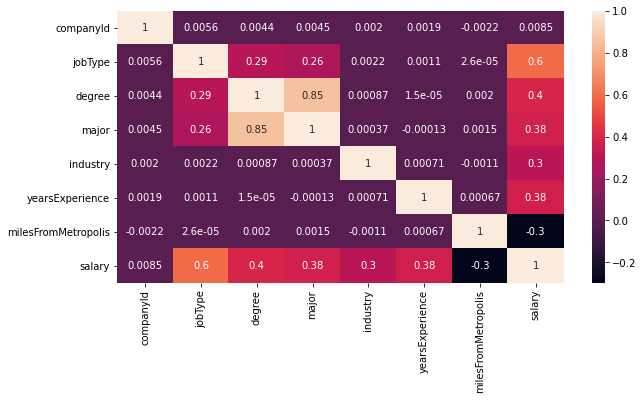

In [55]:
# Plotting the heatmap

plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.heatmap(df_corr.corr(), annot = True)
plt.show()

In [56]:
del(df_corr)

From the heatmap, we can see the correlation between all the feature variables and target variable.

### ---- 5 Establish a baseline ----

I have created a simple baseline model using the average salary and calculating the Mean Squared Error(MSE) on the basis of two feature variables Job Type and Industry.

In [57]:
# Creating a copy of the training data set for basic analysis
df_salMod=df_final.copy(deep=True)

In [58]:
# Predicting the values using avg salary for each Job Type
avg_sal_jT = pd.DataFrame(df_salMod.groupby('jobType')['salary'].mean())
predicted_jT = df_salMod.merge(avg_sal_jT,on='jobType',how='inner')

In [59]:
# Calculating the Mean squared error based on Job Type
mean_sq_err=np.square(np.subtract(predicted_jT['salary_x'],predicted_jT['salary_y'])).mean()
mean_sq_err= round(mean_sq_err,3)
print (mean_sq_err)

963.92


In [60]:
# Predicting the values using avg salary for each Industry
avg_sal_ind = pd.DataFrame(df_salMod.groupby('industry')['salary'].mean())
predicted_ind = df_salMod.merge(avg_sal_ind,on='industry',how='inner')

In [61]:
# Calculating the Mean squared error based on Industry
mean_sq_err=np.square(np.subtract(predicted_ind['salary_x'],predicted_ind['salary_y'])).mean()
mean_sq_err= round(mean_sq_err,3)
print(mean_sq_err)

1367.119


In [62]:
del(df_salMod)

The MSE based on the Job Type is 963.2.
The MSE based on the Industry is 1367.119.

### ---- 6 Hypothesize solution ----

The four models I would like to use to train and test the data are :-

     1) Multiple Linear Regression
     2) Random Forest
     3) Gradient Boosting
     4) Polynomial Regression

## Part 3 - DEVELOP

Create features, tune the models, and train/validate models to reach the goal of MSE less than 360.

### ---- 7 Engineer features  ----

We need to improve the dataset converting categorical columns to numeric using One Hot Encoding technique.

One Hot Coding is applied on the features :- JobType, Degree, Major, Industry

We need to normalize the numerical features yearsExperience and milesFromMetropolis.

In [63]:
# Creating the copy of the Dataset
df_fin_model=df_final.copy(deep=True)

In [64]:
df_fin_model.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salary-binned
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,Medium
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,Low
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,Medium
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,Medium
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,Medium


In [65]:
# Generate binary values using get_dummies method
df_fin_model = pd.get_dummies(df_fin_model, columns=["jobType"])
df_fin_model = pd.get_dummies(df_fin_model, columns=["industry"])
df_fin_model = pd.get_dummies(df_fin_model, columns=["degree"])
df_fin_model = pd.get_dummies(df_fin_model, columns=["major"])
df_fin_model.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,salary-binned,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,...,degree_NONE,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS
0,JOB1362684407687,COMP37,10,83,130,Medium,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,JOB1362684407688,COMP19,3,73,101,Low,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,JOB1362684407689,COMP52,10,38,137,Medium,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,JOB1362684407690,COMP38,8,17,142,Medium,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,COMP7,8,16,163,Medium,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
# Normalizing the data using MinMax scaling method

scaler = MinMaxScaler()
# transform data
df_fin_model[['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(df_fin_model[['yearsExperience', 'milesFromMetropolis']])
df_fin_model.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,salary-binned,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,...,degree_NONE,major_BIOLOGY,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS
0,JOB1362684407687,COMP37,0.416667,0.838384,130,Medium,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,JOB1362684407688,COMP19,0.125000,0.737374,101,Low,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,JOB1362684407689,COMP52,0.416667,0.383838,137,Medium,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,JOB1362684407690,COMP38,0.333333,0.171717,142,Medium,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,COMP7,0.333333,0.161616,163,Medium,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### ---- 8 Create models ----

Define the predictor and target variables.
Split the data into Training and Testing Data.

Used the training dataset to train/fit the model.
Used the testing dataset to test the model.

#### Preparing Data for Model Analysis

In [82]:
# For Model Analysis

# Define the predictor and the target variables X and Y respectively
cat_features = ['jobType','industry','degree','major']
num_features = df_fin_model[['yearsExperience', 'milesFromMetropolis']]
Y = df_final.salary
#X = df_fin_model.iloc[:,6:31]
X = df_final[cat_features]
X = pd.get_dummies(data=X)
X = pd.concat([X,num_features],axis=1)
#X.head()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 100)

#### Multiple Linear Regression (MLR) Model

In [83]:
# For Multiple Linear Regression(MLR) model analysis

# Create the linear regression object using the constructor
regr = linear_model.LinearRegression()

# Fit the model
regr.fit(X_train, Y_train)
regr.score(X_train, Y_train)

# Obtain the prediction
predicted_mlr = regr.predict(X_test)

# Obtain the mean absolute, mean squared, r-squares
mae_MLR = mean_absolute_error(Y_test, predicted_mlr)
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae_MLR))

#print("First in-sample predictions:", regr.predict(X_test.head()))
#print("Actual target values for those homes:", Y.head().tolist())

mse_MLR = mean_squared_error(Y_test, predicted_mlr)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_MLR))

#print("First in-sample predictions:", regr.predict(X_test.head()))
#print("Actual target values for those homes:", Y.head().tolist())
#rmse = np.sqrt(mean_squared_error(Y_test,predicted_lr))
#print(rmse)

r2_MLR = r2_score(Y_test,predicted_mlr)
print("The r squared error (R2) on test set: {:.4f}".format(r2_MLR))

The mean absolute error (MAE) on test set: 15.8104
The mean squared error (MSE) on test set: 382.8616
The r squared error (R2) on test set: 0.7439


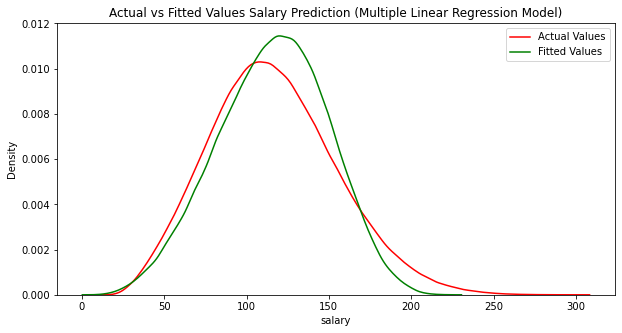

In [84]:
# Multiple Linear Regression Model evaluation using visualisation
ax1=sns.kdeplot(df_fin_model['salary'],color='r',label="Actual Values")
ax1=sns.kdeplot(predicted_mlr,color='g',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (Multiple Linear Regression Model)")
plt.show()

#### Random Forest Regression Model

In [85]:
# For Random Forest Regression Model analysis

forest_model = RandomForestRegressor(n_estimators=200,min_samples_leaf=50,n_jobs=2,max_features="auto",oob_score=True,random_state=100)
forest_model.fit(X_train, Y_train)
predicted_rf = forest_model.predict(X_test)

mae_RF = mean_absolute_error(Y_test, predicted_rf)
mse_RF = mean_squared_error(Y_test, predicted_rf)
r2_RF = r2_score(Y_test,predicted_rf)
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae_RF))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_RF))
print("The r squared error (R2) on test set: {:.4f}".format(r2_RF))
#print(mean_absolute_error(Y_test, predicted_rf))
#print(mean_squared_error(Y_test, predicted_rf))

The mean absolute error (MAE) on test set: 15.5260
The mean squared error (MSE) on test set: 368.9499
The r squared error (R2) on test set: 0.7532


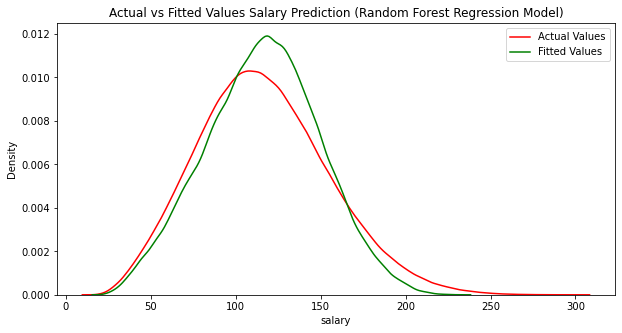

In [87]:
# Random Forest Regression Model evaluation using visualisation
ax1=sns.kdeplot(df_fin_model['salary'],color='r',label="Actual Values")
ax1=sns.kdeplot(predicted_rf,color='g',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (Random Forest Regression Model)")
plt.show()

#### Gradient Boosting Model

In [88]:
# For Gradient Boosting Model analysis

grdbst_model = GradientBoostingRegressor(n_estimators=200,max_depth= 5,loss='ls',random_state=100)
grdbst_model.fit(X_train, Y_train)
predicted_gb = grdbst_model.predict(X_test)

mae_GB = mean_absolute_error(Y_test, predicted_gb)
mse_GB = mean_squared_error(Y_test, predicted_gb)
r2_GB = r2_score(Y_test,predicted_gb)
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae_GB))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_GB))
print("The r squared error (R2) on test set: {:.4f}".format(r2_GB))

The mean absolute error (MAE) on test set: 15.3053
The mean squared error (MSE) on test set: 355.1737
The r squared error (R2) on test set: 0.7624


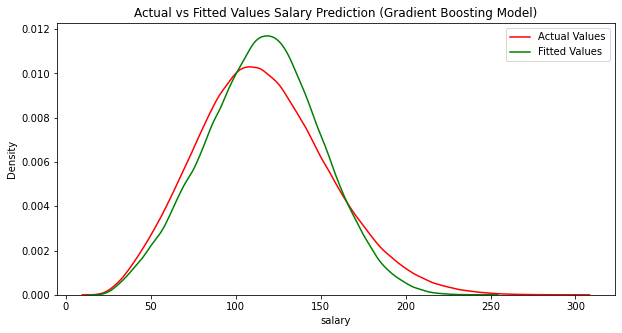

In [89]:
# Gradient Boosting Model evaluation using visualisation
ax1=sns.kdeplot(df_fin_model['salary'],color='r',label="Actual Values")
ax1=sns.kdeplot(predicted_gb,color='g',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (Gradient Boosting Model)")
plt.show()

#### Polynomial Regression Model

In [90]:
# Create the multiple polynomial regression object using the constructor
pr = PolynomialFeatures(degree=2,include_bias=False)

# Transforming the predictor variables equation
X_poly=pr.fit_transform(X)
#print(X_poly)

In [91]:
X_train_pr, X_test_pr, Y_train_pr, Y_test_pr = train_test_split(X_poly, Y, test_size = .20, random_state = 100)

pregr = linear_model.LinearRegression()
# Fit the model
pregr.fit(X_train_pr, Y_train_pr)
#regr.score(X_train, Y_train)

# Obtain the prediction
predicted_pr = pregr.predict(X_test_pr)
#print(predicted)

mae_PR = mean_absolute_error(Y_test_pr, predicted_gb)
mse_PR = mean_squared_error(Y_test_pr, predicted_gb)
r2_PR = r2_score(Y_test_pr,predicted_gb)

print("The mean absolute error (MAE) on test set: {:.4f}".format(mae_PR))
#print("First in-sample predictions:", regr.predict(X_test.head()))
#print("Actual target values for those homes:", Y.head().tolist())

print("The mean squared error (MSE) on test set: {:.4f}".format(mse_PR))
#print("First in-sample predictions:", regr.predict(X_test.head()))
#print("Actual target values for those homes:", Y.head().tolist())

print("The r squared error (R2) on test set: {:.4f}".format(r2_PR))

The mean absolute error (MAE) on test set: 15.3053
The mean squared error (MSE) on test set: 355.1737
The r squared error (R2) on test set: 0.7624


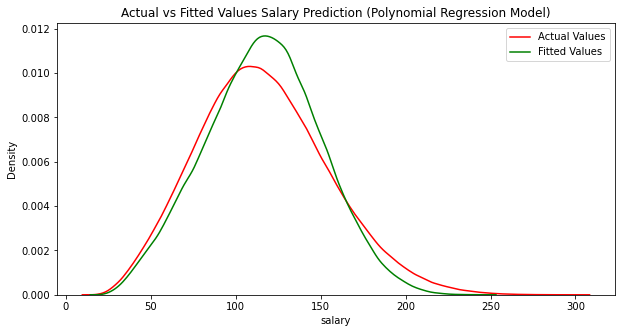

In [92]:
# Polynomial Regression Model evaluation using visualisation
ax1=sns.kdeplot(df_fin_model['salary'],color='r',label="Actual Values")
ax1=sns.kdeplot(predicted_pr,color='g',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (Polynomial Regression Model)")
plt.show()

In [93]:
# Creating a list to strore the results
Analysis_Results = [['Multiple Linear Regression', mae_MLR, mse_MLR, r2_MLR],['Random Forest', mae_RF, mse_RF, r2_RF],['Gradient Boosting', mae_GB, mse_GB, r2_GB],['Polynomial Regression', mae_PR, mse_PR, r2_PR]]
#print(Analysis_Results)
df_Result=pd.DataFrame(Analysis_Results)

#### Results

In [94]:
headers = ["Model","Mean_Absolute_Error","Mean_Squared_Error","R_squared"]
df_Result.columns = headers
df_Result.head()

,Model,Mean_Absolute_Error,Mean_Squared_Error,R_squared
0,Multiple Linear Regression,15.810375,382.861624,0.743921
1,Random Forest,15.525968,368.949864,0.753226
2,Gradient Boosting,15.305319,355.173732,0.762440
3,Polynomial Regression,15.305319,355.173732,0.762440


### ---- 9 Test models ----

In [95]:
#do 5-fold cross validation on models and measure MSE

scores_mlr=cross_val_score(regr,X_train, Y_train,cv=5)
scores_mlr=np.mean(scores_mlr)
print("The cross validation score for Linear Model: {:.4f}".format(scores_mlr))

The cross validation score for Linear Model: 0.7435


In [96]:
scores_rf=cross_val_score(forest_model,X_train, Y_train,cv=5)
scores_rf=np.mean(scores_rf)
print("The cross validation score for Random Forest Model: {:.4f}".format(scores_rf))

The cross validation score for Random Forest Model: 0.7515


In [97]:
scores_gb=cross_val_score(grdbst_model,X_train, Y_train,cv=5)
scores_gb=np.mean(scores_gb)
print("The cross validation score for Gradient Boost Model: {:.4f}".format(scores_gb))

The cross validation score for Gradient Boost Model: 0.7622


In [98]:
scores_pr=cross_val_score(pregr,X_train_pr, Y_train_pr,cv=5)
scores_pr=np.mean(scores_pr)
print("The cross validation score for Polynomial Regression Model: {:.4f}".format(scores_pr))

The cross validation score for Polynomial Regression Model: 0.7638


### ---- 10 Select best model  ----

Both the Models "Polynomial Regression" and "Gradient Boosting" have the lowest MSE error. 

I have selected the model "Gradient Boosting" Model for further analysis.

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [99]:
# Preview of the data in the Testing Dataset
df_test_f.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [100]:
# Information about data in the Testing Dataset
df_test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [101]:
# Create features and prepare the Testing Data for analysis
cat_features_t = ['jobType','industry','degree','major']
df_test_f[['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(df_test_f[['yearsExperience', 'milesFromMetropolis']])

num_features_t = df_test_f[['yearsExperience', 'milesFromMetropolis']]
X_test_f = df_test_f[cat_features_t]
X_test_f = pd.get_dummies(data=X_test_f)
X_test_f = pd.concat([X_test_f,num_features_t],axis=1)
X_test_f.head()

,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,industry_AUTO,industry_EDUCATION,...,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.916667,0.737374
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.833333,0.474747
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.708333,0.090909
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.583333,0.969697
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.416667,0.444444


In [102]:
# Obtain the prediction
predicted_test_data = grdbst_model.predict(X_test_f)

In [103]:
predicted_test_data = pd.DataFrame(predicted_test_data)

In [104]:
pred_df=pd.concat([df_test_f['jobId'],predicted_test_data],axis=1)

In [105]:
pred_df=pred_df.rename(columns={0: "Salary"})

In [106]:
# Preview of the predicted salaries in the Testing Dataset
pred_df.head()

,jobId,Salary
0,JOB1362685407687,112.313675
1,JOB1362685407688,92.126188
2,JOB1362685407689,181.355553
3,JOB1362685407690,105.098965
4,JOB1362685407691,115.015347


#### Feature Importance

With Feature importance, we can assign scores to the Predictor variables fed in the models to predict the target variables.
These scores indicates the importance of each feature when making a prediction.

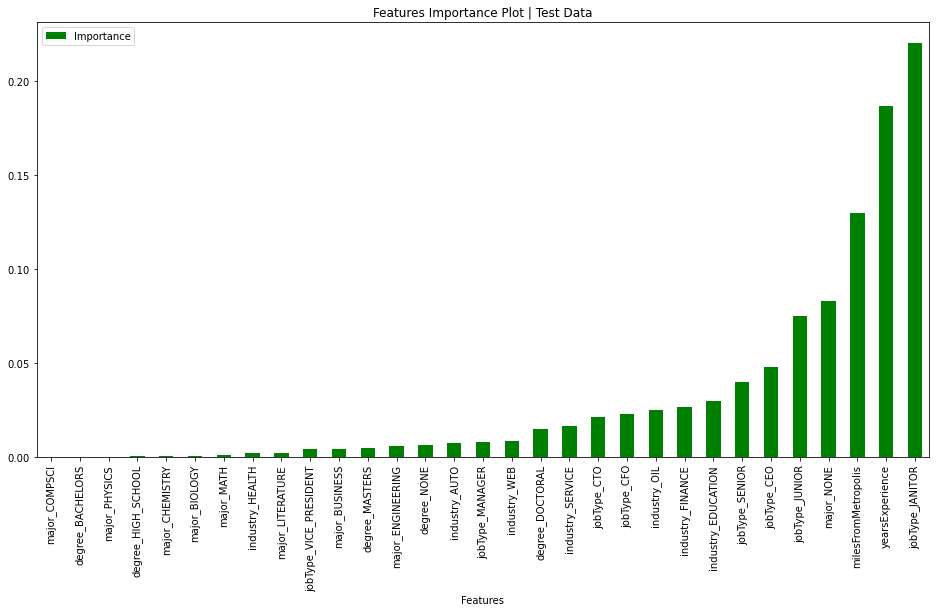

In [107]:
# Get importance from the selected Model
importance = grdbst_model.feature_importances_

# Plot feature importance
important_features = pd.DataFrame({'Feature':X_test_f.columns, "Importance" : importance})
important_features.sort_values(by='Importance',inplace=True)
ax=important_features.plot.bar(x='Feature',rot=90, fontsize=10,color=['green'],figsize=(16,8))
ax.set_title("Features Importance Plot | Test Data")
ax.set_xlabel("Features")
plt.show()

### ---- 12 Deploy solution ----

In [108]:
#save your prediction to a csv file
pred_df.to_csv("/FirstProject/data/test_salaries.csv", index=False)